# Mumbai Real-Estate

In [1]:
%pip install pandas numpy matplotlib scikit-learn joblib


[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: /usr/local/bin/python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import sys, platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import sklearn

# Pretty display
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

# Version print (helps debug env issues)
print("Python:", sys.version.split()[0], "| Platform:", platform.system())
print("numpy:", np.__version__, "| pandas:", pd.__version__, "| scikit-learn:", sklearn.__version__)

# RMSE helper that works on all sklearn versions (no 'squared' arg needed)
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

Python: 3.11.1 | Platform: Darwin
numpy: 1.26.3 | pandas: 2.1.4 | scikit-learn: 1.7.2


In [5]:
# --- Section 2: Load CSV & prepare columns ---

from pathlib import Path

# Path to your CSV file
CSV_PATH = Path("mumbai-house-price-data.csv")

# Load your CSV
df = pd.read_csv(CSV_PATH)
print("Original columns:", list(df.columns))

# Rename columns to match what we need
rename_map = {
    "bedroom_num": "bhk",
    "property_type": "type",
    "city": "region"
}
df.rename(columns=rename_map, inplace=True)

# Create missing columns with default assumptions
df["price_unit"] = "L"  # assume price is in Lakhs
df["status"] = "Ready to move"
df["age"] = df["age"].apply(lambda x: "new" if x == 0 else "resale")

# Keep only required columns
df = df[["bhk", "type", "locality", "area", "price", "price_unit", "region", "status", "age"]]

print("Prepared columns:", list(df.columns))
df.head()

Original columns: ['title', 'price', 'area', 'price_per_sqft', 'locality', 'city', 'property_type', 'bedroom_num', 'bathroom_num', 'balcony_num', 'furnished', 'age', 'total_floors', 'latitude', 'longitude']
Prepared columns: ['bhk', 'type', 'locality', 'area', 'price', 'price_unit', 'region', 'status', 'age']


,bhk,type,locality,area,price,price_unit,region,status,age
0,2,Apartment,Kalyan,757,6600283,L,Mumbai,Ready to move,new
1,2,Apartment,Kalyan,652,6169841,L,Mumbai,Ready to move,new
2,1,Apartment,Dombivali,396,4599936,L,Mumbai,Ready to move,new
3,3,Apartment,Ville Parle,1130,51980000,L,Mumbai,Ready to move,new
4,1,Apartment,Nala Sopara,435,3915000,L,Mumbai,Ready to move,new


In [7]:
# --- Section 3: Clean & engineer features ---

import numpy as np

def to_inr(price, unit):
    """Convert price + unit (L/Cr) to absolute INR."""
    if pd.isna(price) or pd.isna(unit):
        return np.nan
    u = str(unit).strip().lower()
    if u in ("l", "lakh", "lakhs"):
        return float(price) * 1e5
    if u in ("cr", "crore", "crores"):
        return float(price) * 1e7
    # Fallback: assume already INR
    return float(price)

# 1) Tidy strings
for col in ["type", "locality", "region", "status", "age", "price_unit"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

# 2) Coerce numerics
df["bhk"] = pd.to_numeric(df["bhk"], errors="coerce")
df["area"] = pd.to_numeric(df["area"], errors="coerce")
df["price"] = pd.to_numeric(df["price"], errors="coerce")

# 3) Convert to INR + derived features
df["price_inr"] = [to_inr(p, u) for p, u in zip(df["price"], df["price_unit"])]
df["price_million_inr"] = df["price_inr"] / 1e6
df["price_per_sqft"] = df["price_inr"] / df["area"]

# 4) Normalize age to 'new'/'resale' (keep unknown as NaN just in case)
df["age"] = df["age"].replace({"unknown": np.nan, "nan": np.nan, "": np.nan, "None": np.nan})
df["age"] = df["age"].str.lower().replace({"0": "new", "new": "new"}).where(df["age"].notna(), other="resale")

# 5) Basic validity filters
before = len(df)
df = df[(df["bhk"] > 0) & (df["area"] > 0) & (df["price_inr"] > 0)].copy()
after = len(df)

print(f"Rows before: {before} | after cleaning: {after} | dropped: {before - after}")

# Quick sanity peek
df[["bhk","type","locality","region","area","price","price_unit","price_inr","price_per_sqft","status","age"]].head()


Rows before: 71936 | after cleaning: 71936 | dropped: 0


,bhk,type,locality,region,area,price,price_unit,price_inr,price_per_sqft,status,age
0,2,Apartment,Kalyan,Mumbai,757,6600283,L,6.600283e+11,8.719000e+08,Ready to move,new
1,2,Apartment,Kalyan,Mumbai,652,6169841,L,6.169841e+11,9.462946e+08,Ready to move,new
2,1,Apartment,Dombivali,Mumbai,396,4599936,L,4.599936e+11,1.161600e+09,Ready to move,new
3,3,Apartment,Ville Parle,Mumbai,1130,51980000,L,5.198000e+12,4.600000e+09,Ready to move,new
4,1,Apartment,Nala Sopara,Mumbai,435,3915000,L,3.915000e+11,9.000000e+08,Ready to move,new


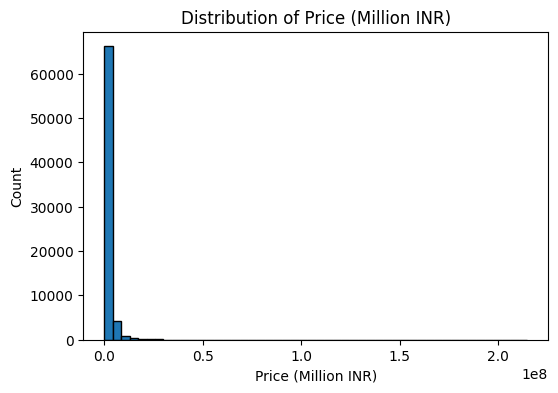

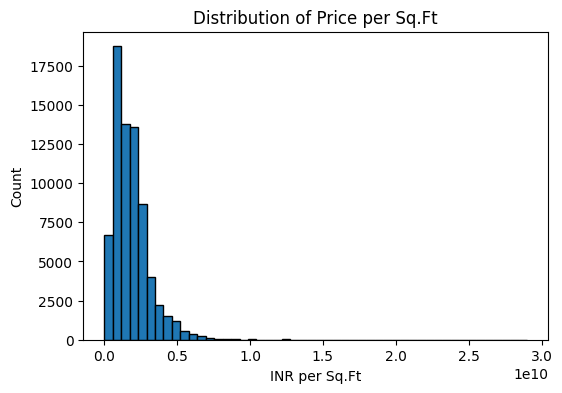

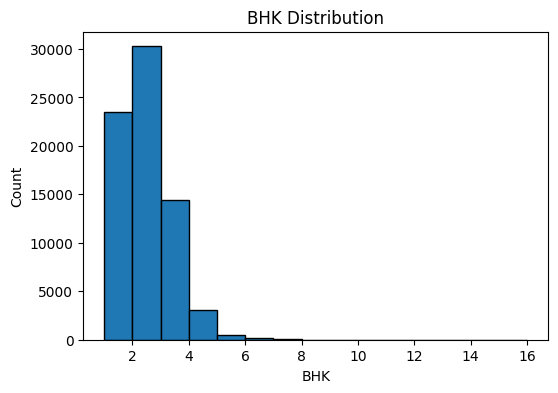

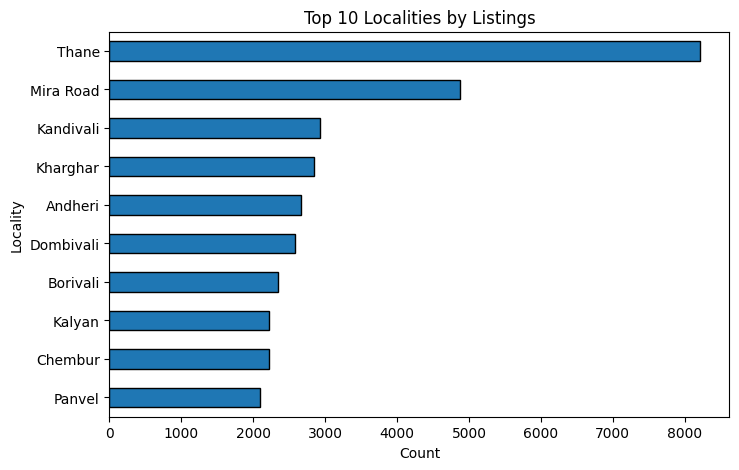

Top 10 Localities:


locality
Thane        8211
Mira Road    4872
Kandivali    2933
Kharghar     2843
Andheri      2671
Dombivali    2585
Borivali     2344
Kalyan       2219
Chembur      2218
Panvel       2098
Name: count, dtype: int64

In [12]:
# --- Section 4: EDA (Exploratory Data Analysis) ---

import matplotlib.pyplot as plt

# 1) Price distribution (in million INR)
plt.figure(figsize=(6,4))
df["price_million_inr"].plot(kind="hist", bins=50, edgecolor="black")
plt.title("Distribution of Price (Million INR)")
plt.xlabel("Price (Million INR)")
plt.ylabel("Count")
plt.show()

# 2) Price per sq.ft distribution
plt.figure(figsize=(6,4))
df["price_per_sqft"].plot(kind="hist", bins=50, edgecolor="black")
plt.title("Distribution of Price per Sq.Ft")
plt.xlabel("INR per Sq.Ft")
plt.ylabel("Count")
plt.show()

# 3) BHK count distribution
plt.figure(figsize=(6,4))
df["bhk"].plot(kind="hist", bins=range(1, int(df["bhk"].max())+2), edgecolor="black")
plt.title("BHK Distribution")
plt.xlabel("BHK")
plt.ylabel("Count")
plt.show()

# 4) Top 10 localities by listing count
top_localities = df["locality"].value_counts().head(10)
plt.figure(figsize=(8,5))
top_localities.sort_values().plot(kind="barh", edgecolor="black")
plt.title("Top 10 Localities by Listings")
plt.xlabel("Count")
plt.ylabel("Locality")
plt.show()

print("Top 10 Localities:")
display(top_localities)


In [13]:
# --- Section 5: Outlier filtering based on price_per_sqft ---

def iqr_filter(series, k=1.5):
    """Return boolean mask for values within IQR bounds."""
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - k * iqr, q3 + k * iqr
    return (series >= lower) & (series <= upper)

# Apply within each (locality, bhk) group
mask = df.groupby(["locality", "bhk"])["price_per_sqft"].transform(iqr_filter)

df_clean = df[mask.fillna(True)].copy()

print(f"Original rows: {len(df)}")
print(f"After outlier filtering: {len(df_clean)}")
print(f"Removed {len(df) - len(df_clean)} outliers")

# Quick check of cleaned price_per_sqft range
df_clean["price_per_sqft"].describe()


Original rows: 71936
After outlier filtering: 69888
Removed 2048 outliers


count    6.988800e+04
mean     1.821739e+09
std      1.207144e+09
min      7.476636e+07
25%      9.230769e+08
50%      1.602700e+09
75%      2.362511e+09
max      1.642222e+10
Name: price_per_sqft, dtype: float64

In [15]:
# --- Section 6: Baseline Comparable-Median Predictor ---

from sklearn.metrics import mean_absolute_error, r2_score

# 1) Compute median price_per_sqft by locality & bhk
locality_bhk_pps = df_clean.groupby(["locality", "bhk"])["price_per_sqft"].median()
region_bhk_pps = df_clean.groupby(["region", "bhk"])["price_per_sqft"].median()
global_pps = df_clean["price_per_sqft"].median()

def baseline_predict(row):
    """Predict price using median ₹/sqft from similar properties."""
    pps = locality_bhk_pps.get((row["locality"], row["bhk"]), np.nan)
    if np.isnan(pps):
        pps = region_bhk_pps.get((row["region"], row["bhk"]), np.nan)
    if np.isnan(pps):
        pps = global_pps
    return pps * row["area"]

# 2) Train-test split
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df_clean, test_size=0.2, random_state=42)

# 3) Predictions
y_true = test_df["price_inr"].values
y_pred = test_df.apply(baseline_predict, axis=1).values

# 4) Metrics
mae = mean_absolute_error(y_true, y_pred)
rmse_val = rmse(y_true, y_pred)  # using helper from Section 1
r2 = r2_score(y_true, y_pred)

print("Baseline Model Performance:")
print(f"MAE   : ₹{mae:,.0f}")
print(f"RMSE  : ₹{rmse_val:,.0f}")
print(f"R²    : {r2:.3f}")


Baseline Model Performance:
MAE   : ₹428,653,137,448
RMSE  : ₹1,356,782,197,349
R²    : 0.837


In [17]:
# --- Section 7: ML Models (RandomForest & GradientBoosting) ---

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# 1) Prepare features
work = df_clean.copy()
work["area_per_bhk"] = work["area"] / work["bhk"]

# Limit localities to top 30 (reduce one-hot encoding size)
top_localities = work["locality"].value_counts().head(30).index
work["locality_reduced"] = np.where(work["locality"].isin(top_localities), work["locality"], "Other")

# Define features and target
features = ["bhk", "area", "area_per_bhk", "type", "region", "status", "age", "locality_reduced"]
target = "price_inr"

X = work[features]
y = work[target]

# 2) Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3) Preprocessing
num_features = ["bhk", "area", "area_per_bhk"]
cat_features = ["type", "region", "status", "age", "locality_reduced"]

numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])

preprocess = ColumnTransformer([
    ("num", numeric_transformer, num_features),
    ("cat", categorical_transformer, cat_features)
])

# 4) Define models
rf_model = Pipeline([
    ("preprocess", preprocess),
    ("rf", RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))
])

gbr_model = Pipeline([
    ("preprocess", preprocess),
    ("gbr", GradientBoostingRegressor(random_state=42))
])

# 5) Train and evaluate
for name, model in [("Random Forest", rf_model), ("Gradient Boosting", gbr_model)]:
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse_val = rmse(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f" {name} → MAE: ₹{mae:,.0f} | RMSE: ₹{rmse_val:,.0f} | R²: {r2:.3f}")


 Random Forest → MAE: ₹454,076,756,722 | RMSE: ₹1,267,692,095,494 | R²: 0.858
 Gradient Boosting → MAE: ₹652,046,549,626 | RMSE: ₹1,419,570,662,949 | R²: 0.822


In [18]:
# --- Section 8: Select best model & save it ---

from sklearn.model_selection import cross_val_score
import joblib
from pathlib import Path

# 1) Compare using cross-validation RMSE
def crossval_rmse(pipeline, X, y, cv=5):
    scores = cross_val_score(pipeline, X, y, scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1)
    return -scores.mean()

rf_rmse_cv = crossval_rmse(rf_model, X_train, y_train, cv=5)
gbr_rmse_cv = crossval_rmse(gbr_model, X_train, y_train, cv=5)

print(f"Cross-val RMSE → RandomForest: ₹{rf_rmse_cv:,.0f} | GradientBoosting: ₹{gbr_rmse_cv:,.0f}")

# 2) Choose best
if rf_rmse_cv <= gbr_rmse_cv:
    best_model = rf_model
    best_name = "RandomForest"
else:
    best_model = gbr_model
    best_name = "GradientBoosting"

print(f"Selected best model: {best_name}")

# 3) Fit on full dataset
best_model.fit(X, y)

# 4) Save model
MODEL_PATH = Path("mumbai_price_model.joblib")
joblib.dump(best_model, MODEL_PATH)
print(f"Model saved at: {MODEL_PATH.resolve()}")


Cross-val RMSE → RandomForest: ₹1,473,092,902,439 | GradientBoosting: ₹1,579,503,226,637
Selected best model: RandomForest
Model saved at: /Users/manavmangela/Desktop/Data_Engineer/Mumbai_Real_Estate/mumbai_price_model.joblib


In [19]:
# --- Quick helper for custom predictions ---

loaded = joblib.load(MODEL_PATH)

def predict_price(bhk, area, ptype, region, status, age, locality):
    """Return predicted price in INR using saved model."""
    area_per_bhk = area / bhk
    loc_reduced = locality if locality in top_localities else "Other"
    row = pd.DataFrame([{
        "bhk": bhk,
        "area": area,
        "area_per_bhk": area_per_bhk,
        "type": ptype,
        "region": region,
        "status": status,
        "age": age,
        "locality_reduced": loc_reduced
    }])
    pred_inr = loaded.predict(row)[0]
    return pred_inr, pred_inr / 1e6  # return in INR and Million INR

# 🔍 Example prediction:
example_price, example_price_mn = predict_price(
    bhk=2,
    area=800,
    ptype="Apartment",
    region="Mumbai",
    status="Ready to move",
    age="new",
    locality="Kalyan"
)
print(f"Predicted Price: ₹{example_price:,.0f} (~₹{example_price_mn:.2f} Million)")


Predicted Price: ₹674,255,286,991 (~₹674255.29 Million)


In [20]:
# --- Section 9: Export cleaned CSV & create SQLite DB ---

from pathlib import Path
import sqlite3

# 1) Export cleaned data
CLEAN_PATH = Path("mumbai_house_prices_cleaned.csv")
df_clean.to_csv(CLEAN_PATH, index=False)
print("Cleaned CSV saved at:", CLEAN_PATH.resolve())

# 2) Create SQLite DB and schema
DB_PATH = Path("mumbai_housing.db")
if DB_PATH.exists():
    DB_PATH.unlink()  # recreate

schema_sql = """
PRAGMA foreign_keys = ON;

DROP TABLE IF EXISTS mumbai_listings;

CREATE TABLE mumbai_listings (
    id              INTEGER PRIMARY KEY AUTOINCREMENT,
    bhk             INTEGER NOT NULL CHECK (bhk > 0),
    type            TEXT    NOT NULL,
    locality        TEXT    NOT NULL,
    region          TEXT    NOT NULL,
    status          TEXT    NOT NULL,
    age             TEXT,
    area_sqft       REAL    NOT NULL CHECK (area_sqft > 0),
    price_inr       REAL    NOT NULL CHECK (price_inr > 0)
);

CREATE INDEX IF NOT EXISTS idx_loc     ON mumbai_listings(locality);
CREATE INDEX IF NOT EXISTS idx_region  ON mumbai_listings(region);
CREATE INDEX IF NOT EXISTS idx_bhk     ON mumbai_listings(bhk);
CREATE INDEX IF NOT EXISTS idx_status  ON mumbai_listings(status);
"""

conn = sqlite3.connect(DB_PATH)
conn.executescript(schema_sql)

# 3) Prepare rows and insert
sql_df = df_clean.rename(columns={"area": "area_sqft"})[
    ["bhk", "type", "locality", "region", "status", "age", "area_sqft", "price_inr"]
].copy()

insert_sql = """
INSERT INTO mumbai_listings
(bhk, type, locality, region, status, age, area_sqft, price_inr)
VALUES (?, ?, ?, ?, ?, ?, ?, ?);
"""

conn.executemany(insert_sql, list(sql_df.itertuples(index=False, name=None)))
conn.commit()

# 4) Quick verification
n_rows = conn.execute("SELECT COUNT(*) FROM mumbai_listings;").fetchone()[0]
print(f"SQLite DB created at: {DB_PATH.resolve()} | Rows loaded: {n_rows}")

conn.close()


Cleaned CSV saved at: /Users/manavmangela/Desktop/Data_Engineer/Mumbai_Real_Estate/mumbai_house_prices_cleaned.csv
SQLite DB created at: /Users/manavmangela/Desktop/Data_Engineer/Mumbai_Real_Estate/mumbai_housing.db | Rows loaded: 69888


In [21]:
# --- Section 10: SQL analytics (run queries from SQLite) ---

import sqlite3
import pandas as pd

DB_PATH = "mumbai_housing.db"
conn = sqlite3.connect(DB_PATH)

# 1) Inventory by status
q1 = """
SELECT status, COUNT(*) AS listings
FROM mumbai_listings
GROUP BY status
ORDER BY listings DESC;
"""
print("▶ Inventory by status")
display(pd.read_sql(q1, conn))

# 2) Average price-per-sqft by region
q2 = """
SELECT region, ROUND(AVG(price_inr/area_sqft), 2) AS avg_price_per_sqft
FROM mumbai_listings
GROUP BY region
ORDER BY avg_price_per_sqft DESC;
"""
print("▶ Avg price per sqft by region")
display(pd.read_sql(q2, conn))

# 3) Top 10 localities by listings
q3 = """
SELECT locality, COUNT(*) AS listings
FROM mumbai_listings
GROUP BY locality
ORDER BY listings DESC
LIMIT 10;
"""
print("▶ Top 10 localities by listings")
display(pd.read_sql(q3, conn))

# 4) Approximate median price (₹) by BHK using window trick
q4 = """
WITH ranked AS (
  SELECT
    bhk,
    price_inr,
    ROW_NUMBER() OVER (PARTITION BY bhk ORDER BY price_inr)      AS rn_asc,
    ROW_NUMBER() OVER (PARTITION BY bhk ORDER BY price_inr DESC) AS rn_desc,
    COUNT(*)    OVER (PARTITION BY bhk)                          AS n
  FROM mumbai_listings
)
SELECT
  bhk,
  AVG(price_inr) AS approx_median_price_inr
FROM ranked
WHERE rn_asc IN ( (n+1)/2, (n/2)+1 )
GROUP BY bhk
ORDER BY bhk;
"""
print("▶ Approx median price by BHK (INR)")
display(pd.read_sql(q4, conn))

conn.close()


▶ Inventory by status


,status,listings
0,Ready to move,69888


▶ Avg price per sqft by region


,region,avg_price_per_sqft
0,Mumbai South,5.798325e+09
1,Western Mumbai,3.548825e+09
2,Central Mumbai,2.992103e+09
3,Mumbai,1.794584e+09


▶ Top 10 localities by listings


,locality,listings
0,Thane,8117
1,Mira Road,4841
2,Kandivali,2918
3,Kharghar,2744
4,Dombivali,2578
5,Andheri,2517
6,Borivali,2319
7,Chembur,2163
8,Kalyan,2137
9,Panvel,2054


▶ Approx median price by BHK (INR)


,bhk,approx_median_price_inr
0,1,5.900000e+11
1,2,1.349946e+12
2,3,2.579947e+12
3,4,5.250000e+12
4,5,9.000000e+12
5,6,1.082500e+13
6,7,1.451000e+13
7,8,2.500000e+13
8,9,2.700000e+13
9,10,2.850000e+13
